# Dogs vs Cats with pre-trained CNN

The goal of this notebook is to classify whether images contain either a dog or a cat. We will use "transfer learning" 


The data for this competition can be found [here](https://www.kaggle.com/c/dogs-vs-cats).



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle competitions download -d  dogs-vs-cats -p PATH` <br/>

You can also get the data from fast.ai <br/>
`wget http://files.fast.ai/data/dogscats.zip`

In [3]:
PATH = Path("/data2/yinterian/dogscats/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/dogscats/valid'),
 PosixPath('/data2/yinterian/dogscats/test1'),
 PosixPath('/data2/yinterian/dogscats/sample'),
 PosixPath('/data2/yinterian/dogscats/train'),
 PosixPath('/data2/yinterian/dogscats/models')]

In [4]:
! ls /data2/yinterian/dogscats/train

cats  dogs


In [5]:
! ls /data2/yinterian/dogscats/train/cats | head

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


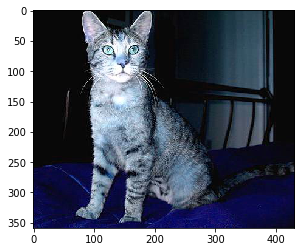

In [9]:
path = PATH/"train/cats/cat.10000.jpg"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im)

In [10]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(359, 431, 3)

In [11]:
# let's look at the typical size of these images
path = PATH/"train/cats"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(411, 500, 3),
 (374, 500, 3),
 (374, 500, 3),
 (479, 400, 3),
 (349, 400, 3),
 (374, 498, 3),
 (374, 500, 3),
 (431, 288, 3),
 (317, 336, 3),
 (399, 310, 3)]

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [12]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

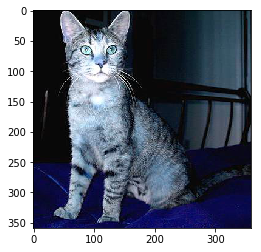

In [15]:
path = PATH/"train/cats/cat.10000.jpg"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

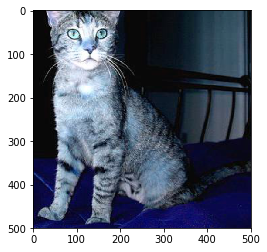

In [17]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im2 = random_crop(im, 500, 500)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

4.1513669775288005


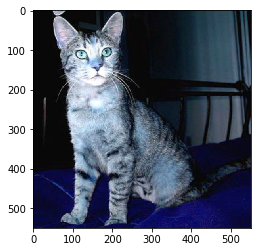

In [18]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

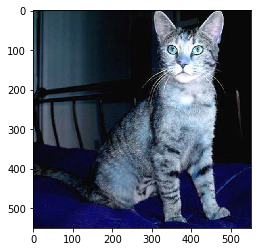

In [19]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Dataset

In [63]:
class DogsCatsDataset(Dataset):
    def __init__(self, PATH, train="train", sz=224):
        self.path_to_images = PATH/train
        self.transforms = False
        if train == "train": self.transforms = True
        self.sz = sz
        self.sz2 = int(sz*1.05)
        self.cats_files = list((self.path_to_images/"cats").iterdir())
        self.dogs_files = list((self.path_to_images/"dogs").iterdir())
        self.files = self.cats_files + self.dogs_files
        # cats 1, dogs, 0
        self.y = np.concatenate((np.ones(len(self.cats_files), dtype=int),
                                np.zeros(len(self.dogs_files), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)/255
        # center crop
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # substract numbers from resnet34
        return np.rollaxis(x, 2), self.y[idx]

In [64]:
train_ds = DogsCatsDataset(PATH/"sample", "train")
valid_ds = DogsCatsDataset(PATH/"sample", "valid")

In [66]:
len(train_ds)

16

In [71]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [72]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [73]:
x.shape,y

((3, 224, 224), 1)

## Model

In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [132]:
model = Net().cuda()

In [133]:
x, y = next(iter(train_dl))

In [144]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([5, 3, 224, 224])

In [145]:
x_features = model.top_model(x)
x_features.shape

torch.Size([5, 512, 7, 7])

In [146]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([5, 512, 1, 1])

In [147]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([5, 512])

In [148]:
y_hat = model(x)
y_hat

tensor([[-0.1179],
        [ 0.3905],
        [ 0.2492],
        [-0.6136],
        [-0.0924]], device='cuda:0')

In [149]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(1))

tensor(0.7267, device='cuda:0')

## Learning rate finder

In [50]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[ind])
            x1, x2 = x
            x1 = Variable(x1).cuda().float()
            x2 = Variable(x2).cuda().float()
            y = Variable(y).cuda().float()
            out = model((x1, x2))
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.data[0])
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [51]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

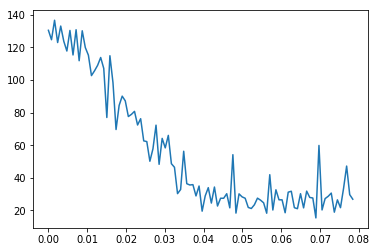

In [52]:
plt.plot(lrs[:100], losses[:100])
plt.show()

## Triangular learning rate training

In [40]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [41]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [42]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.012):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x1, x2 = x
            x1 = Variable(x1).cuda().float()
            x2 = Variable(x2).cuda().float()
            y = Variable(y).cuda().float()
            out = model((x1, x2))
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.data[0])
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [43]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return loss.data[0]

## Training with triangular rates

In [44]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.035):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [53]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [54]:
model = Net().cuda()

In [ ]:
training_loop(model, train_dl, valid_dl, steps=3)

train loss 41.26657229380135
val loss 19.36207680698428
train loss 20.495719833668947
val loss 18.52866042558396
train loss 17.315726088229795
val loss 15.275490372829452
train loss 16.187740735415012
val loss 15.988812630371287
----End of step Time elapsed 0:12:23.086787
train loss 17.15633530606835
val loss 16.567169519193016
train loss 19.083373382928315
val loss 17.924638952365665
train loss 16.590446430954568
val loss 15.123298348556144
train loss 15.653060767137564
val loss 14.525678769262134
----End of step Time elapsed 0:12:21.591675


In [48]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-5, lr_high=0.01)

train loss 19.07630597811315
val loss 18.97558538995027


KeyboardInterrupt: 

##  Old Train
We will optimize the mean absolute error (MAE). (reduced the learning rate by 20% after 10 epochs of plateau.)

In [30]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [31]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.data[0])
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [32]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return loss.data[0]

In [33]:
from datetime import datetime
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs):
        start = datetime.now()
        loss = train_model(model, optim, train_dl)
        end = datetime.now()
        t = 'Time elapsed (hh:mm:ss.ms) {}'.format(end - start)
        print("loss ", i, loss, t)
        val_loss(model, valid_dl)

In [202]:
model = Net().cuda()

In [196]:
#optim = get_optimizer(model, lr =.1, wd =0.0)
#loss = train_model(model, optim, train_dl, verbose=True)

In [ ]:
train_loop(model, epochs=10, lr=0.05, wd=0.0)

loss  0 25.42381304921356 Time elapsed (hh:mm:ss.ms) 0:06:52.184968
val loss 21.78213216764978
loss  1 22.93895130571495 Time elapsed (hh:mm:ss.ms) 0:06:48.731716
val loss 25.597907902039204
loss  2 22.949015871173316 Time elapsed (hh:mm:ss.ms) 0:06:50.755646
val loss 30.4551635155311


In [199]:
train_loop(model, epochs=5, lr=0.01, wd=0.0)

loss  0 22.688820816336474 Time elapsed (hh:mm:ss.ms) 0:07:31.593901
val loss 38.12631136041894
loss  1 22.361299535755315 Time elapsed (hh:mm:ss.ms) 0:07:30.885606
val loss 25.887596184823554
loss  2 21.570579890276587 Time elapsed (hh:mm:ss.ms) 0:07:29.306271
val loss 34.76482062827586
loss  3 22.21368067568695 Time elapsed (hh:mm:ss.ms) 0:07:31.287805
val loss 44.95899109987869
loss  4 21.931672756706643 Time elapsed (hh:mm:ss.ms) 0:07:14.145659
val loss 114.62090645622962


In [200]:
train_loop(model, epochs=10, lr=0.05, wd=0.0)

loss  0 20.63055352808309 Time elapsed (hh:mm:ss.ms) 0:06:52.502617
val loss 44.536520455017815
loss  1 20.858483895188293 Time elapsed (hh:mm:ss.ms) 0:06:53.006997
val loss 23.057963258590515
loss  2 20.358289297986566 Time elapsed (hh:mm:ss.ms) 0:06:50.582808
val loss 28.259199981931463
loss  3 20.152358686643947 Time elapsed (hh:mm:ss.ms) 0:06:54.801470
val loss 22.971267816663072
loss  4 20.214510212214925 Time elapsed (hh:mm:ss.ms) 0:06:52.656795
val loss 18.867837117835702
loss  5 20.257653116435478 Time elapsed (hh:mm:ss.ms) 0:06:48.848347
val loss 24.422670319002833
loss  6 19.952387873369517 Time elapsed (hh:mm:ss.ms) 0:06:47.606855
val loss 28.978002785690997
loss  7 19.899387100995597 Time elapsed (hh:mm:ss.ms) 0:06:50.093288
val loss 25.409397203897694
loss  8 20.231367348844792 Time elapsed (hh:mm:ss.ms) 0:06:51.715739
val loss 450.82946668741346
loss  9 19.914776464699163 Time elapsed (hh:mm:ss.ms) 0:06:49.957171
val loss 96.48424045704925


In [201]:
train_loop(model, epochs=10, lr=0.001, wd=0.0)

loss  0 19.422038737438942 Time elapsed (hh:mm:ss.ms) 0:06:51.503859
val loss 44.48694043231332
loss  1 19.290576821383073 Time elapsed (hh:mm:ss.ms) 0:06:50.401860
val loss 415.2714099415137
loss  2 18.94845641400181 Time elapsed (hh:mm:ss.ms) 0:06:49.660736
val loss 42.5225834993972
loss  3 18.98380877400002 Time elapsed (hh:mm:ss.ms) 0:06:48.348070
val loss 133.15389306161444
loss  4 18.990029486169284 Time elapsed (hh:mm:ss.ms) 0:06:48.807190
val loss 37.84855611469895
loss  5 18.88756720423521 Time elapsed (hh:mm:ss.ms) 0:06:51.187389
val loss 36.87360717567728
loss  6 19.06422029461777 Time elapsed (hh:mm:ss.ms) 0:06:50.782960
val loss 58.055282775794204
loss  7 18.862142909777177 Time elapsed (hh:mm:ss.ms) 0:06:48.151119
val loss 54.527085155272275
loss  8 18.911628512540272 Time elapsed (hh:mm:ss.ms) 0:06:47.198518
val loss 94.80104538829056
loss  9 18.983565504906117 Time elapsed (hh:mm:ss.ms) 0:06:49.089641
val loss 40.1905147392158


In [ ]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [97]:
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [145]:
val_loss(model, valid_dl)

val loss 19.491879188664655


20.56451988220215

In [149]:
p = PATH/"model005.pth"
save_model(model, p)

In [ ]:
# load model
p = PATH/"model005.pth"
model.load_state_dict(torch.load(p))

In [172]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [173]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [175]:
unfreeze(model, 7)

In [177]:
train_loop(model, epochs=5, lr=0.001, wd=0.0000)

Time elapsed (hh:mm:ss.ms) 0:07:46.733371
loss  0 13.772853367344476
Time elapsed (hh:mm:ss.ms) 0:07:54.559377
loss  1 13.18771737913793
val loss 17.323107559089145
Time elapsed (hh:mm:ss.ms) 0:07:55.942199
loss  2 13.481891490290854
Time elapsed (hh:mm:ss.ms) 0:07:54.645739
loss  3 13.227313383209987
val loss 12.371409078895999
Time elapsed (hh:mm:ss.ms) 0:07:29.913418
loss  4 12.72860453553946


In [178]:
train_loop(model, epochs=5, lr=0.0001, wd=0.0000)

Time elapsed (hh:mm:ss.ms) 0:07:54.343334
loss  0 12.432673157567086
Time elapsed (hh:mm:ss.ms) 0:07:55.405003
loss  1 12.29912730290805
val loss 15.374370425963194
Time elapsed (hh:mm:ss.ms) 0:07:53.842612
loss  2 12.189770003874695
Time elapsed (hh:mm:ss.ms) 0:07:54.364371
loss  3 12.134659048657621
val loss 12.232453401461184
Time elapsed (hh:mm:ss.ms) 0:07:17.849029
loss  4 12.082688829851335


# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb